# Monte Carlo sampling 
Als alternatief voor _grid search_ zouden we via _sampling_ kunnen werken.

1. We starten met een eerste berekende gok voor de parameters en berekenen de SSE _loss_ bij de start
2. Daarna itereren we (30k keer) over volgende stappen:
    - We nemen een sample uit een normale verdeling met gemiddelde $0$ om een kleine aanpassing te doen aan de parameterschattingen (in positieve of negatieve zin).
    - We zorgen dat de bijgewerkte schattingen binnen een realistisch interval blijven.
    - We berekenen de SSE _loss_ opnieuw. Als de nieuwe SSE is gedaald, behouden we de nieuwe parameterwaarden. In het andere geval verwerpen we ze.

In [1]:
import numpy as np

from ml_courses.sim.monte_carlo_tips import MonteCarloTipsSimulation

In [2]:
# Generate data
sim = MonteCarloTipsSimulation()

# Random number generator for reproducibility
rng = np.random.default_rng(67)
# rng = np.random.default_rng(123)

# Initial guesses
b1 = rng.uniform(0, 10)  # Base tip: Between $0 and $10
b2 = rng.uniform(0.05, 0.50)  # Tip rate: Between 5% and 50%

# Initial SSE loss
current_loss = sim.calculate_loss(b1, b2, sim.order_totals, sim.observed_tips)
print(f"Current SSE loss: {current_loss:.2f} (with guess: ${b1:.2f} + {b2:.1%} × order)")

# Containers to keep track of all our attempts
b1_samples = []
b2_samples = []
loss_samples = []

n_accepted = 0  # Count how many proposals we accepted
n_samples = 30000  # Total number of samples to draw
step_size = 0.0001  # How big of a step to take when proposing new

for i in range(n_samples):
    # Propose slight changes to our current best guess
    b1_new = b1 + rng.normal(0, step_size * 5)  # Base tip can vary more
    b2_new = b2 + rng.normal(0, step_size)

    # Keep parameters reasonable (tip rate: 0-50%, base tip: $0-5)
    b1_new = np.clip(b1_new, 0, 50)
    b2_new = np.clip(b2_new, 0, 1.0)

    new_loss = sim.calculate_loss(b1_new, b2_new, sim.order_totals, sim.observed_tips)

    # Decide whether this new relationship is worth keeping
    accept = False
    if new_loss < current_loss:
        # This predicts tips better - definitely keep it!
        accept = True

    if accept:
        b1 = b1_new
        b2 = b2_new
        current_loss = new_loss
        n_accepted += 1

    # Record our current best guess (whether we moved or stayed)
    b1_samples.append(b1)
    b2_samples.append(b2)
    loss_samples.append(current_loss)

    # Show progress
    if i == 0 or (i + 1) % 1000 == 0:
        tip_pct = b2 * 100
        # print(f"Sample {i + 1:5d}: {tip_pct:.1f}% + ${b1:.2f} base, loss={current_loss:.1f}")
        print(
            f"Sample {i + 1:5d}: Tip = ${b1:.2f} + {b2:.1%} × Order Total, loss={current_loss:.1f}"
        )

acceptance_rate = n_accepted / n_samples
print(f"\n✅ Finished! Accepted {acceptance_rate:.1%} of proposed changes")

Current SSE loss: 472.96 (with guess: $4.14 + 10.7% × order)
Sample     1: Tip = $4.14 + 10.7% × Order Total, loss=472.8
Sample  1000: Tip = $4.07 + 6.8% × Order Total, loss=303.0
Sample  2000: Tip = $4.00 + 2.9% × Order Total, loss=181.2
Sample  3000: Tip = $3.93 + 0.0% × Order Total, loss=120.2
Sample  4000: Tip = $3.80 + 0.0% × Order Total, loss=104.2
Sample  5000: Tip = $3.65 + 0.0% × Order Total, loss=88.5
Sample  6000: Tip = $3.50 + 0.0% × Order Total, loss=75.2
Sample  7000: Tip = $3.35 + 0.0% × Order Total, loss=63.7
Sample  8000: Tip = $3.19 + 0.0% × Order Total, loss=54.4
Sample  9000: Tip = $3.02 + 0.1% × Order Total, loss=46.7
Sample 10000: Tip = $2.84 + 0.9% × Order Total, loss=40.4
Sample 11000: Tip = $2.64 + 2.0% × Order Total, loss=34.2
Sample 12000: Tip = $2.45 + 3.2% × Order Total, loss=28.5
Sample 13000: Tip = $2.26 + 4.3% × Order Total, loss=23.5
Sample 14000: Tip = $2.07 + 5.5% × Order Total, loss=19.1
Sample 15000: Tip = $1.87 + 6.6% × Order Total, loss=15.0
Sampl

## Visualisatie van het SSE oppervlak

Nu we de Monte Carlo sampling hebben uitgevoerd, kunnen we stappen visualiseren op het SSE oppervlak. Zo zien we hoe het algoritme "bergafwaarts" beweegt naar het minimum.

In [4]:
from ml_courses.sim.linear_regression_sse_viz import LinearRegressionSSEVisualizer

viz = LinearRegressionSSEVisualizer(
    x_data=sim.order_totals,
    y_data=sim.observed_tips,
    true_bias=sim.true_b1,
    true_slope=sim.true_b2,
)

fig = viz.create_3d_surface_plot(
    bias_samples=np.array(b1_samples),
    slope_samples=np.array(b2_samples),
    loss_samples=np.array(loss_samples),
    resolution=40,
)
fig.show()

::: {tip}
Probeer de Monte Carlo sampling ook eens met een andere _seed_ voor de random generator.
``` python
rng = np.random.default_rng(123)
```
Wat merk je?
:::

Hieronder herhalen we het naïeve Monte Carlo algorithme 10 keer en visualiseren we de resulterende regressielijnen.

In [5]:
b1_sims = []
b2_sims = []

for _ in range(10):
    sim_run = sim.run_simulation()
    print(
        f"Estimated relationship: Tip = ${sim_run['final_b1']:.2f} + {sim_run['final_b2']:.1%} × Order Total"
    )
    b1_sims.append(sim_run["final_b1"])
    b2_sims.append(sim_run["final_b2"])

Estimated relationship: Tip = $5.75 + 0.0% × Order Total
Estimated relationship: Tip = $4.65 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $3.33 + 0.0% × Order Total
Estimated relationship: Tip = $5.60 + 0.0% × Order Total
Estimated relationship: Tip = $6.05 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $4.40 + 0.0% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total
Estimated relationship: Tip = $0.56 + 14.3% × Order Total


In [6]:
import matplotlib.pyplot as plt

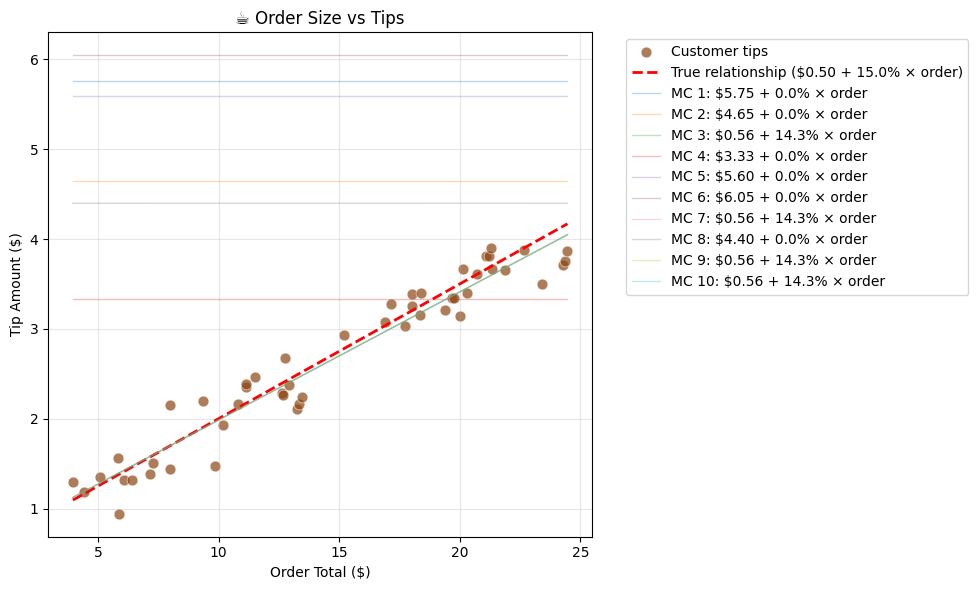

In [7]:
# Plot the simulations
plt.figure(figsize=(10, 6))
plt.scatter(
    sim.order_totals,
    sim.observed_tips,
    alpha=0.7,
    color="saddlebrown",
    s=60,
    edgecolor="white",
    linewidth=0.5,
    label="Customer tips",
)
plt.plot(
    sim.order_totals,
    sim.true_tips,
    "r--",
    linewidth=2,
    label=f"True relationship (${sim.true_b1:.2f} + {sim.true_b2:.1%} × order)",
)

colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

for i, (b1_sim, b2_sim) in enumerate(zip(b1_sims, b2_sims, strict=False)):
    sim_tips = b1_sim + b2_sim * sim.order_totals
    plt.plot(
        sim.order_totals,
        sim_tips,
        color=colors[i],
        linestyle="-",
        alpha=0.3,
        linewidth=1,
        label=f"MC {i + 1}: ${b1_sim:.2f} + {b2_sim:.1%} × order",
    )

plt.xlabel("Order Total ($)")
plt.ylabel("Tip Amount ($)")
plt.title("☕ Order Size vs Tips")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

De simpele Monte Carlo benadering levert duidelijk onstabiele resultaten op. In de volgende secties bekijken we betere alternatieven op basis van _calculus_. Daarvoor behandelen we eerst het concept van de **gradient** van de _loss_ functie.